# Sentiment Analysis of **Oppenheimer** movie reviews from IMDB

<img src="Img/imdb website.png" width="800" />

**Scraping the reviews from the imdb website for oppenheimer movie**

Importing the librarires for web scraping

In [1]:
import time
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
# Set up Chrome WebDriver
driver = webdriver.Chrome()

url = "https://www.imdb.com/title/tt15398776/reviews?ref_=tt_urv"
driver.get(url)

**Since all the reviews are only seen when the load more button is clicked, we are going to automate the process using selenium ChromeWebdriver**

In [3]:
# Wait for the page to load and the "Load More" button to become clickable
wait = WebDriverWait(driver, 10)

# Scroll down the page and wait for new reviews to load
while True:
    try:
        load_more_button = wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "ipl-load-more__button")))
        driver.execute_script("arguments[0].scrollIntoView();", load_more_button)
        load_more_button.click()
        time.sleep(2)  # Allow time for new reviews to load
    except Exception:
        break

# Extract all the reviews
reviews = driver.find_elements(By.CSS_SELECTOR, ".lister-item-content .text.show-more__control")

# Save the reviews to a CSV file
with open("imdb_reviews.csv", mode="w", encoding="utf-8", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Review"])

    for review in reviews:
        review_text = review.text.strip()
        writer.writerow([review_text])

driver.quit()

Importing libraries for Sentiment analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [5]:
df = pd.read_csv("imdb_reviews.csv")
df.head(10)

,Review
0,You'll have to have your wits about you and yo...
1,One of the most anticipated films of the year ...
2,"""Oppenheimer"" is a biographical thriller film ..."
3,This movie is just... wow! I don't think I hav...
4,I may consider myself lucky to be alive to wat...
5,NaN
6,I'm still collecting my thoughts after experie...
7,Oppenheimer might be the best film I watched i...
8,"Master craftsman, Christopher Nolan - probably..."
9,Just came out of the theater and watching Oppe...


In [6]:
df.shape

(2225, 1)

In [7]:
df.isnull().sum()

Review    418
dtype: int64

These 408 reviews were redacted by the users because it had spoilers. We can just remove those

**Removing null values**

In [8]:
df=df.dropna()

In [9]:
df.isnull().sum()

Review    0
dtype: int64

In [10]:
df.shape

(1807, 1)

In [11]:
dup=df.duplicated()
print(df[dup])

                                                 Review
50    When you see Oppenheimer, what catches your at...
1249  I may consider myself lucky to be alive to wat...
1256  You'll have to have your wits about you and yo...
1426  The cinematic genius Christopher Nolan is undo...
1709  Movie skillfully combines the elements of acti...
1794  I may consider myself lucky to be alive to wat...


So there are **six duplicates**. Let's remove them

In [12]:
df=df.drop_duplicates(keep="first")
df.shape

(1801, 1)

In [13]:
def clean_review(review):
    review = review.replace('\n', ' ')   # Remove newline characters
    review = review.replace('\\', '')    # Remove backslash characters
    review = review.replace('\'', '')    # Remove single quotes
    return review

df['Review'] = df['Review'].apply(clean_review)

In [29]:
example = df['Review'][8]
example

'Master craftsman, Christopher Nolan - probably the best blockbuster director out there (along with Ridley Scott) - returns to good old fashioned no-CGI drama, where tension comes from words spoken, and how people react to them. There are no chases, no shoot-outs , death defying stunts or explosions.... wait, actually there is one explosion. I dont know how they made those scenes without CGI, but its technical achievement for sure.  All shot in 70mm IMAX this is beautiful film. And the lead cast - all seasoned actors - do a terrific job.  My only gripe is that its a tad too long. The final act could/should have been trimmed. But its still the best movie I have seen this year.  I strongly recommend to watch this on an IMAX screen before its taken down in a month or so.'

**Now, the text are way better for sentiment analysis**

# Vader model

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

# Note

**If the SentimentIntensityAnalyzer() is not working, use the below code, otherwise no need to run this code**

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [30]:
example=df["Review"][8]

In [31]:
sia.polarity_scores(example)

{'neg': 0.048, 'neu': 0.749, 'pos': 0.203, 'compound': 0.9795}

**Wow the sentiment of the review by the vader model is good,the compound is near to +1, therefore the review is positive**

In [32]:
compound_scores = []
positive_scores = []
negative_scores = []
neutral_scores = []

# Iterate through the DataFrame and calculate polarity scores
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    scores = sia.polarity_scores(text)
    compound_scores.append(scores['compound'])
    positive_scores.append(scores['pos'])
    negative_scores.append(scores['neg'])
    neutral_scores.append(scores['neu'])

df['V_Compound_Score'] = compound_scores
df['V_Positive_Score'] = positive_scores
df['V_Negative_Score'] = negative_scores
df['V_Neutral_Score'] = neutral_scores

  0%|          | 0/1801 [00:00<?, ?it/s]

Run the below cell individually to see how well the vader model performs 

In [ ]:
# df['Review'][2154]
# df['Review'][2155]
# df['Review'][2143]
# df['Review'][2149]
# df['Review'][2190]
# df['Review'][2140]
# df['Review'][2149]
# df['Review'][2149]

In [33]:
df['Review'][18]

'My Review - Oppenheimer My Rating Ten plus 10/10 In Cinemas now  If there were to be a movie to represent the last one hundred years of existence on our planet to be placed in a time capsule and opened in 100 years time if by any chance our planet is still in existence it should be Oppenheimer.  This is truly an astonishing achievement in Cinema storytelling covering a wide arc of world events and the personalities that played pivotal roles in the 20th Century that affect us today many that are still responsible for the fear and instability around the Globe.  Oppenheimer written and directed by Christopher Nolan is a chilling disturbing but engrossing movie to sit through 3 hours but its very so very enlightening.  I found it Shakespearian in its portrayal of human folly and the pursuit of power that corrupts when jealousy and lies spread like cancer to undermine reputations .  Detestable characters like Hitler, J Edgar Hoover , Senator Joseph McCarthy ,Mussolini are mentioned to esta

The above cell indicates the model has some problem in predicting the sentiment. Even tho it is positive, vader model marks it as negative

In [34]:
df.head(10)

,Review,V_Compound_Score,V_Positive_Score,V_Negative_Score,V_Neutral_Score
0,Youll have to have your wits about you and you...,0.9902,0.184,0.050,0.766
1,One of the most anticipated films of the year ...,0.9975,0.236,0.048,0.716
2,"""Oppenheimer"" is a biographical thriller film ...",0.9986,0.148,0.097,0.755
3,This movie is just... wow! I dont think I have...,0.9908,0.223,0.060,0.718
4,I may consider myself lucky to be alive to wat...,0.9253,0.167,0.045,0.788
6,Im still collecting my thoughts after experien...,0.8873,0.131,0.063,0.806
7,Oppenheimer might be the best film I watched i...,0.9896,0.183,0.031,0.785
8,"Master craftsman, Christopher Nolan - probably...",0.9795,0.203,0.048,0.749
9,Just came out of the theater and watching Oppe...,0.9958,0.287,0.023,0.690
10,Everybody involved with the production of Oppe...,0.9992,0.149,0.062,0.790


# Textblob model

In [35]:
from textblob import TextBlob
from tqdm.notebook import tqdm

textblob_scores = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    blob = TextBlob(text)
    textblob_scores.append(blob.sentiment.polarity)

df['TextBlob_Score'] = textblob_scores

  0%|          | 0/1801 [00:00<?, ?it/s]

In [36]:
df.head(10)

,Review,V_Compound_Score,V_Positive_Score,V_Negative_Score,V_Neutral_Score,TextBlob_Score
0,Youll have to have your wits about you and you...,0.9902,0.184,0.050,0.766,0.337667
1,One of the most anticipated films of the year ...,0.9975,0.236,0.048,0.716,0.259009
2,"""Oppenheimer"" is a biographical thriller film ...",0.9986,0.148,0.097,0.755,0.160257
3,This movie is just... wow! I dont think I have...,0.9908,0.223,0.060,0.718,0.292188
4,I may consider myself lucky to be alive to wat...,0.9253,0.167,0.045,0.788,0.234615
6,Im still collecting my thoughts after experien...,0.8873,0.131,0.063,0.806,0.242708
7,Oppenheimer might be the best film I watched i...,0.9896,0.183,0.031,0.785,0.155246
8,"Master craftsman, Christopher Nolan - probably...",0.9795,0.203,0.048,0.749,0.308519
9,Just came out of the theater and watching Oppe...,0.9958,0.287,0.023,0.690,0.273611
10,Everybody involved with the production of Oppe...,0.9992,0.149,0.062,0.790,0.180092


**We can clearly see that textblob does not do well**

# Flair model

In [37]:
from flair.models import TextClassifier
from flair.data import Sentence
from tqdm.notebook import tqdm

# Load the pre-trained Flair sentiment analysis model
classifier = TextClassifier.load('en-sentiment')

flair_scores = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    sentence = Sentence(text)
    classifier.predict(sentence)
    flair_scores.append(sentence.labels[0].score)

df['Flair_Score'] = flair_scores

  0%|          | 0/1801 [00:00<?, ?it/s]

In [38]:
df.head(10)

,Review,V_Compound_Score,V_Positive_Score,V_Negative_Score,V_Neutral_Score,TextBlob_Score,Flair_Score
0,Youll have to have your wits about you and you...,0.9902,0.184,0.050,0.766,0.337667,0.999992
1,One of the most anticipated films of the year ...,0.9975,0.236,0.048,0.716,0.259009,0.999030
2,"""Oppenheimer"" is a biographical thriller film ...",0.9986,0.148,0.097,0.755,0.160257,0.999638
3,This movie is just... wow! I dont think I have...,0.9908,0.223,0.060,0.718,0.292188,0.999995
4,I may consider myself lucky to be alive to wat...,0.9253,0.167,0.045,0.788,0.234615,0.999964
6,Im still collecting my thoughts after experien...,0.8873,0.131,0.063,0.806,0.242708,0.999986
7,Oppenheimer might be the best film I watched i...,0.9896,0.183,0.031,0.785,0.155246,0.999992
8,"Master craftsman, Christopher Nolan - probably...",0.9795,0.203,0.048,0.749,0.308519,0.999991
9,Just came out of the theater and watching Oppe...,0.9958,0.287,0.023,0.690,0.273611,0.999974
10,Everybody involved with the production of Oppe...,0.9992,0.149,0.062,0.790,0.180092,0.971205


**The Flair model performance is even worse than textblob**

**Therefore we can see that the vader model is the one which performs well, So we will use the vader model**

In [39]:
df.columns

Index(['Review', 'V_Compound_Score', 'V_Positive_Score', 'V_Negative_Score',
       'V_Neutral_Score', 'TextBlob_Score', 'Flair_Score'],
      dtype='object')

In [40]:
df=df.drop(columns=['V_Positive_Score', 'V_Negative_Score',
       'V_Neutral_Score', 'TextBlob_Score', 'Flair_Score'])

In [41]:
df.head()

,Review,V_Compound_Score
0,Youll have to have your wits about you and you...,0.9902
1,One of the most anticipated films of the year ...,0.9975
2,"""Oppenheimer"" is a biographical thriller film ...",0.9986
3,This movie is just... wow! I dont think I have...,0.9908
4,I may consider myself lucky to be alive to wat...,0.9253


In [42]:
#Let's rename the column name as Sentiment
df=df.rename({'V_Compound_Score':'Sentiment'},axis=1)
df

,Review,Sentiment
0,Youll have to have your wits about you and you...,0.9902
1,One of the most anticipated films of the year ...,0.9975
2,"""Oppenheimer"" is a biographical thriller film ...",0.9986
3,This movie is just... wow! I dont think I have...,0.9908
4,I may consider myself lucky to be alive to wat...,0.9253
...,...,...
2220,Totally underwhelmed with Oppenheimer. Enrico...,0.9747
2221,Extremely boring and long movie. Thinking that...,0.6773
2222,Bla bla bla three hours of talking and talking...,0.8623
2223,"Oppenheimer is a long, slow-burning film that ...",0.8911


In [43]:
def sentiment(label):
    if label <0.5:
        return "Negative"
    elif 0.5 <= label <= 0.72:
        return "Neutral"
    elif label>0.72:
        return "Positive"

In [44]:
df['Sentiment'] = df['Sentiment'].apply(sentiment)

In [45]:
df.head()

,Review,Sentiment
0,Youll have to have your wits about you and you...,Positive
1,One of the most anticipated films of the year ...,Positive
2,"""Oppenheimer"" is a biographical thriller film ...",Positive
3,This movie is just... wow! I dont think I have...,Positive
4,I may consider myself lucky to be alive to wat...,Positive


Yes, Finally done but we can see that in rare cases, the model doesn't predict the sentiment properly

In [46]:
df[df["Sentiment"]=="Neutral"]

,Review,Sentiment
131,Overambitieus movie with too many stories to t...,Neutral
215,Oppenheimer is an enthralling character drama ...,Neutral
242,The casting is phenomenal. A lot of people wil...,Neutral
278,The film is interesting from a political point...,Neutral
360,The only thing that kept me from giving this f...,Neutral
...,...,...
2132,"Great movie, but with a great fault; not a min...",Neutral
2136,"Another Christopher Nolan masterpiece, as it s...",Neutral
2187,Dont watch! Sheer wastage of money. Only lawye...,Neutral
2212,"I suppose these reviews are tweaked, otherwise...",Neutral


In [47]:
df["Review"][2125]

'If i could give zero i would. Boring, long and waste of money. I was expecting more about how was the bomb designed and how he actually did. But nothing. I understand more from Wikipedia. Im afraid the film "Oppenheimer" fell flat in more than a few areas. The most noticeable issue was the pacing; the movie was an exhausting, drawn-out affair that rarely managed to hold my interest. Rather than focusing on the most poignant parts of Oppenheimers life and work, it was bogged down in needless minutiae.  The characterization of Oppenheimer himself was another major flaw. For such a complex and historically significant figure, the movie offered a disappointingly one-dimensional portrayal. The acting was passable but lacked the depth and nuance necessary to truly capture the essence of this troubled genius.  Finally, the storytelling was lackluster. Crucial historical events were glossed over or presented without context, leaving the viewer to grapple with a disjointed narrative that faile

**Wow, the vader model used is pretty good, the sentiments are on point except a very few**

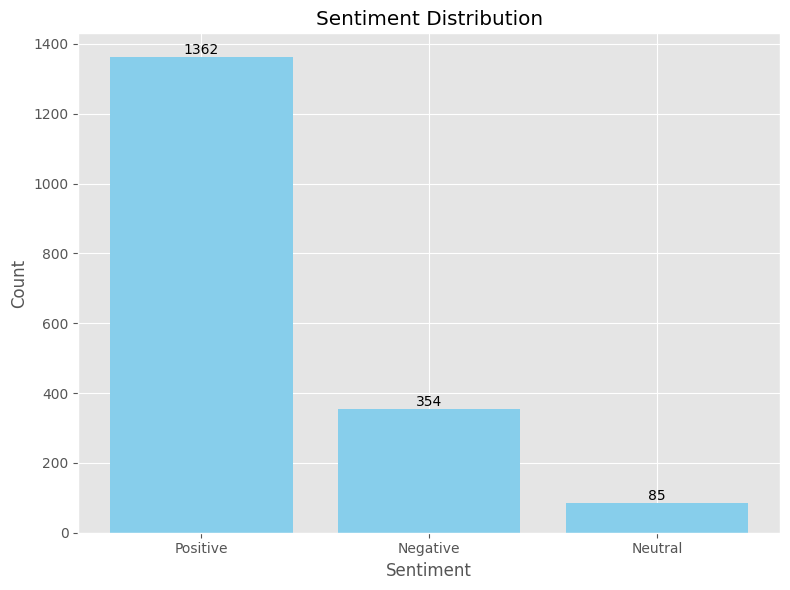

In [48]:
import matplotlib.pyplot as plt


value_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In this bar chart, we can see that the movie **"Oppenheimer"** have more **Postive** reviews

In [ ]:
# Interactive pyechart

# from pyecharts import options as opts
# from pyecharts.charts import Bar

# value_counts = df['Sentiment'].value_counts()

# bar = Bar()
# bar.add_xaxis(value_counts.index.tolist())
# bar.add_yaxis('', value_counts.values.tolist(), itemstyle_opts=opts.ItemStyleOpts(color='skyblue'))
# bar.set_global_opts(title_opts=opts.TitleOpts(title='Sentiment Distribution'), xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-45)))
# bar.render_notebook()

##  <font color="lightpink">**Let's move on to barbie, shall we... :P**</font>
